In [248]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import pandas as pd
import numpy as np

# Business Understanding

Airbnb is a renowned platform that allows home and apartment owners to offer their properties for short-term stays to guests. With its convenience and flexibility, it has emerged as a preferred option among travelers. In this article, we will delve into the Airbnb Seattle dataset and address three key business questions mentioned below;

Q1: In which months does price variation usually occur? and at what times do prices remain constant?<br/>

Q2: Where are most of the accommodations concentrated in price variations? <br/>

Q3: How well can we predict the type of cancellation policy for bookings?

#### variables

In [137]:
date_ref = pd.to_datetime('2016-01-01')

## 1. Reading datas

Through the Inside Airbnb website, I was able to access three important databases related to the city of Boston.
1. The first database, called "listings.csv.gz", provides detailed information about the listings. This includes details about the listed properties, such as location, amenities, prices, and much more.
2. The second database, "calendar.csv.gz", offers detailed information about the calendar. This can include information about the availability of listings over time, booking dates, and other related details.
3. The third database, "reviews.csv.gz", contains detailed information about the reviews. This includes customer reviews for the listings, providing insights into customer experiences and feedback.
These databases are a rich source of information that can be used to better understand the short-term rental market in Boston.

In [249]:
calender = pd.read_csv('dados-airbnb/calendar.csv')
listings = pd.read_csv('dados-airbnb/listings.csv')
reviews = pd.read_csv('dados-airbnb/reviews.csv')

## 2. Understanding of data and answers

In [139]:
calender['price'] = calender['price'].replace('nan', pd.NA)
calender = calender.dropna(subset=['price'])

# adapting col price to ideal format for value data
calender['price'] = calender['price'].replace({'\$': '', ',': ''}, regex=True)
calender['price'] = pd.to_numeric(calender['price'])
calender['price'] = calender['price'].round(2)

In [140]:
# creating a new column to record the year for each data entry
calender['date'] = pd.to_datetime(calender['date'])

# creating variables of time of informations
calender['year'] = calender['date'].dt.year 
calender['month'] = calender['date'].dt.month_name()

In [141]:
# as there is little data for the year 2017, we will consider the analysis only over 2016
calender = calender.loc[calender['year'] == 2016]

In [142]:
# get max price for each year 
df_prices_max = calender.groupby(['listing_id', 'month', 'year'])['price'].max().reset_index()
df_prices_max.rename(columns={'price': 'max_price'}, inplace=True)

In [143]:
# get min price for each year 
df_prices_min = calender.groupby(['listing_id', 'month', 'year'])['price'].min().reset_index()
df_prices_min.rename(columns={'price': 'min_price'}, inplace=True)

In [144]:
# join info prices to operations and analysis
df_prices_min_reset = df_prices_min.reset_index()
df_prices = df_prices_max.join(df_prices_min_reset.set_index(['listing_id', 'month', 'year']), on=['listing_id', 'month', 'year'], how='inner')

In [145]:
#function for temperature price variation within the months of each year
def calculate_difference(row):
    return row['max_price'] - row['min_price']

df_prices['price_difference'] = df_prices.apply(calculate_difference, axis=1)
#formated price
df_prices['price_difference'] = df_prices['price_difference'].map('{:.2f}'.format).astype(float)

## Q1. In which months does price variation usually occur? and at what times do prices remain constant?

the dataframe generated for analysis brings, according to the data contained in the source, the listed accommodation and its maximum and minimum price within each month in which there is data. In total we have 33K thousand records. Check out:

In [108]:
df_prices

,listing_id,month,year,max_price,index,min_price,price_difference
0,3335,April,2016,120.0,0,120.0,0.0
1,3335,August,2016,120.0,1,120.0,0.0
2,3335,December,2016,120.0,2,120.0,0.0
3,3335,February,2016,120.0,3,120.0,0.0
4,3335,July,2016,120.0,4,120.0,0.0
...,...,...,...,...,...,...,...
33179,10340165,March,2016,43.0,33179,43.0,0.0
33180,10340165,May,2016,43.0,33180,43.0,0.0
33181,10340165,November,2016,43.0,33181,43.0,0.0
33182,10340165,October,2016,43.0,33182,43.0,0.0


given that we have the possibility to identify whether there has been a variation in the price of accommodation on a monthly basis,
let's check how many accommodations do not vary their prices in the month:

In [109]:
df_prices.loc[df_prices['price_difference'] == 0.00].shape[0]

20224

therefore, there are 20K listings of accommodations with no price change in random months. Making a comparison with the number of lines in the original df, we noticed that 60% of the accommodations over the months do not change their prices.

Let's understand a little more how is the distribution of accommodations in the months that there was no price change below:

In [110]:
df_non_variation = df_prices.loc[df_prices['price_difference'] == 0.00].groupby(['month'])['listing_id'].count().sort_values(ascending=False)

To better visualize the relationship between months in which accommodations do not change their prices and number of accommodations per month, let's analyze the graph below:

Based on the analysis of Graphic 1 just below, it is possible to notice that price stability tends to be higher in the last months of the year, except for the month of April:

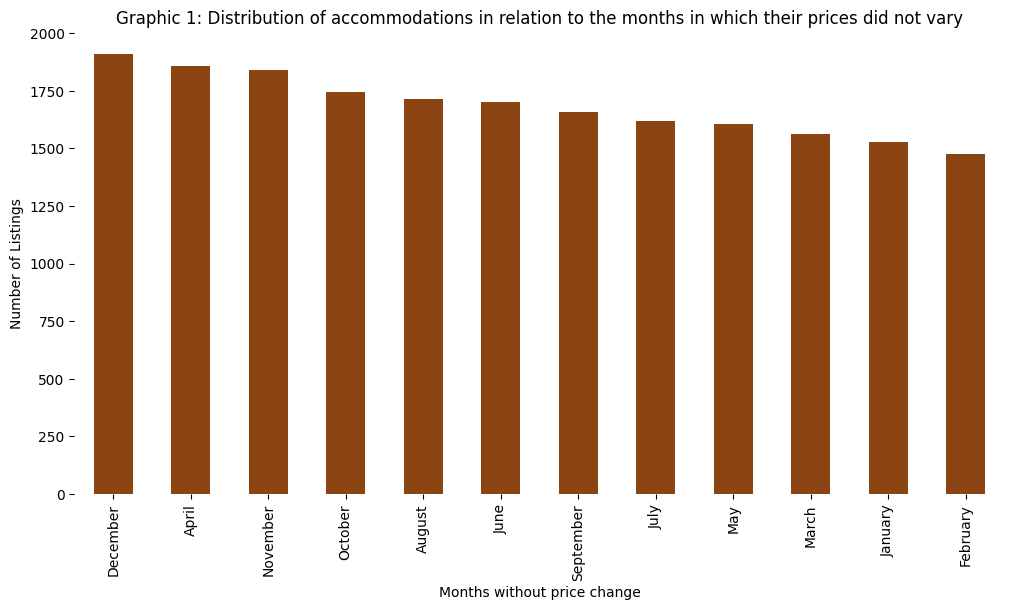

In [260]:
df_non_variation.plot(kind='bar', figsize=(12,6), color='#8B4513')

# Define o título e os rótulos dos eixos
plt.title('Graphic 1: Distribution of accommodations in relation to the months in which their prices did not vary')
plt.xlabel('Months without price change')
plt.ylabel('Number of Listings')

plt.gca().spines["top"].set_alpha(0)    
plt.gca().spines["bottom"].set_alpha(0)
plt.gca().spines["right"].set_alpha(0)    
plt.gca().spines["left"].set_alpha(0) 

# Mostra o gráfico
plt.show()

Complementing the analysis above, we note that when analyzing the monthly records of price variations that are different from zero, that is, where there was a price variation within the month's window, the first months of the year come out with a larger quantity of accommodations that vary their prices. Observe the chart 2:

In [112]:
df_variation= df_prices.loc[df_prices['price_difference'] > 0.00].groupby(['month'])['listing_id'].count().sort_values(ascending=False)

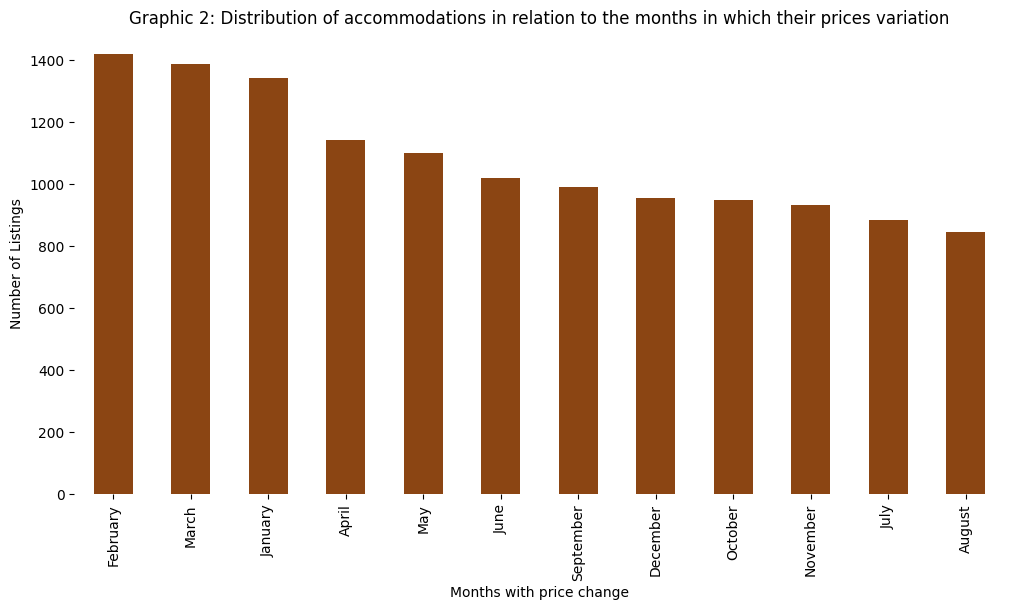

In [261]:
df_variation.plot(kind='bar', figsize=(12,6), color='#8B4513')

# Define o título e os rótulos dos eixos
plt.title('Graphic 2: Distribution of accommodations in relation to the months in which their prices variation')
plt.xlabel('Months with price change')
plt.ylabel('Number of Listings')

plt.gca().spines["top"].set_alpha(0)    
plt.gca().spines["bottom"].set_alpha(0)
plt.gca().spines["right"].set_alpha(0)    
plt.gca().spines["left"].set_alpha(0) 

# Mostra o gráfico
plt.show()

Graphs 1 and 2 show the stability and variation of Airbnb accommodation prices throughout the year. Graph 1 indicates greater price stability in the last months of the year, suggesting more predictable demand. Graph 2 reveals greater price variation in the first months, possibly due to seasonal events or market adjustments. These analyses can guide owners on when to adjust prices to maximize revenue and occupancy. For customers, these data can assist in travel planning, choosing periods of greater stability or price variation according to their flexibility.

## Q2. How are accommodations distributed in relation to the identified price variations?

Most accommodations show a low price variation, between $1 and $50, indicating stability. 
However, a significant portion shows higher price variations:

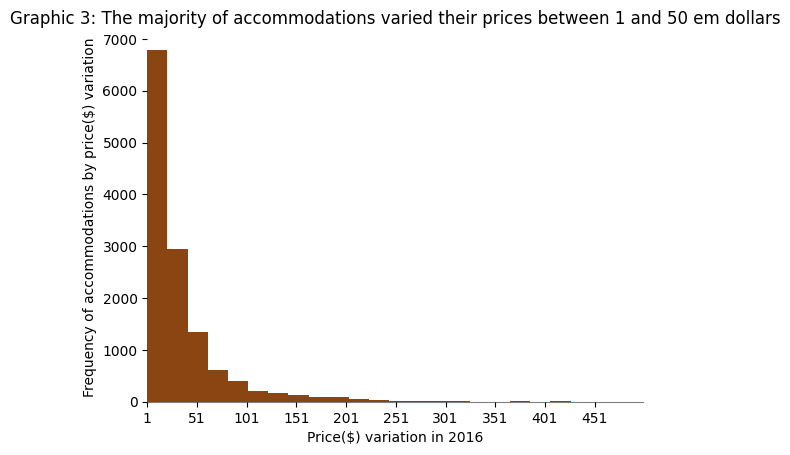

In [262]:
df_prices_range = df_prices.loc[df_prices['price_difference'] > 0.00]
plt.hist(df_prices_range["price_difference"], bins=50, edgecolor="none", color='#8B4513')
plt.xticks(np.arange(min(df_prices_range["price_difference"]), max(df_prices_range["price_difference"])+1, 50))
plt.xlim([min(df_prices_range["price_difference"]), 500])

# Adiciona um título ao gráfico e legendas aos eixos
plt.title("Graphic 3: The majority of accommodations varied their prices between 1 and 50 em dollars")
plt.xlabel("Price($) variation in 2016")
plt.ylabel("Frequency of accommodations by price($) variation")

plt.gca().spines["top"].set_alpha(0.0) 
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0)

## Q3. How well can we predict the type of cancellation policy for bookings?

To answer this question, we will use a machine learning model. But first, let's generate the input for this model:

### Generating features

Generating a feature that represents the total number of comments for each listing. The listings that do not appear here or that
have NaN lines, their number of comments will be equal to zero:

In [156]:
reviews_availabls = reviews[reviews['comments'].notnull()]
reviews_features = reviews_availabls.groupby('listing_id')['comments'].count().reset_index()
reviews_features.rename(columns={'comments': 'total_comments'}, inplace=True)
reviews_features['listing_id'] = reviews_features['listing_id'].astype('object')

selecting columns that can be potential features of df listings and treating:

In [169]:
# selecting the columns that will be used throughout the procedures
listings_features = listings[['id', 'minimum_nights', 'maximum_nights', 'smart_location', 'room_type', 'property_type', 
                     'host_since', 'host_response_rate',  'accommodates','bathrooms', 'bedrooms', 'beds',
                     'bed_type', 'cleaning_fee', 'security_deposit', 'require_guest_profile_picture',
                     'instant_bookable', 'review_scores_value', 'cancellation_policy']].copy()

In [170]:
# renamed col key to default
listings_features.rename(columns={'id': 'listing_id'}, inplace = True)
listings_features['listing_id'] = listings_features['listing_id'].astype('object')

In [171]:
# treating the column that host_since, which brings each in which the host registered
listings_features['host_since'] = pd.to_datetime(listings['host_since'], format='%Y-%m-%d')

# adapting column to generate host age feature in days
listings_features['age_days_host'] = (date_ref - listings_features['host_since']).dt.days

# as the column was recreated above, we eliminated the original one
listings_features = listings_features.drop('host_since', axis=1)

In [172]:
listings_features['host_response_rate'] = listings_features['host_response_rate'].str.replace('%', '').astype(float)
listings_features['host_response_rate'] = listings_features['host_response_rate'].fillna(0)  / 100

In [173]:
listings_features['security_deposit'] = listings_features['security_deposit'].replace({'\$': '', ',': ''}, regex=True)
listings_features['security_deposit'] = pd.to_numeric(listings_features['security_deposit'])
listings_features['security_deposit'] = listings_features['security_deposit'].round(2).fillna(0)

In [174]:
listings_features['cleaning_fee'] = listings_features['cleaning_fee'].replace({'\$': '', ',': ''}, regex=True)
listings_features['cleaning_fee'] = pd.to_numeric(listings_features['cleaning_fee'])
listings_features['cleaning_fee'] = listings_features['cleaning_fee'].round(2).fillna(0)

Now, we will create the last characteristic, which is the average price of each hosting:

In [175]:
# get max price for each year 
calender_features = calender.groupby('listing_id')['price'].mean().reset_index()
calender_features.rename(columns={'price': 'price_avg'}, inplace=True)
calender_features['price_avg'] = calender_features['price_avg'].round(2)
calender_features['listing_id'] = calender_features['listing_id'].astype('object')

Consolidating all the data extracted from the dataframes into a single source:

In [181]:
data_total = listings_features.merge(reviews_features, on='listing_id', suffixes=('_df1', '_df2'))

In [212]:
data_total = data_total.merge(calender_features, on='listing_id', suffixes=('_df1', '_df2'))

To end the treatment step, let's deal with the objective column, which is **cancellation_policy**:

In [183]:
le = LabelEncoder()
data_total['cancellation_policy'] = le.fit_transform(data_total['cancellation_policy'])

Now we will do the final treatment to apply the model. We will eliminate NA columns and handle the categorical columns below:

In [203]:
df = data_total.dropna(subset=['cancellation_policy'], axis=0)
y = df['cancellation_policy']

#Drop respondent and expected salary columns
df = df.drop(['listing_id', 'cancellation_policy'], axis=1)

# Fill numeric columns with the mean
num_vars = df.select_dtypes(include=['float', 'int']).columns
for col in num_vars:
    df[col].fillna((df[col].mean()), inplace=True)
    
# Dummy the categorical variables
cat_vars = df.select_dtypes(include=['object']).copy().columns
for var in  cat_vars:
    # for each cat add dummy var, drop original column
    df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)

X = df

Before applying the model, let's select features based on their importance: 

In [205]:
# Fit the model
model = RandomForestClassifier()
model.fit(X, y)

importances = model.feature_importances_
feature_importances = pd.DataFrame({"feature": X.columns, "importance": importances})
feature_importances = feature_importances.sort_values("importance", ascending=False)
selected_features = feature_importances["feature"][:10].to_list()

In [218]:
# selecting features of max importance
X = X[selected_features]

Applying decision tree algorithm to try to predict cancellation policy type:

In [219]:
# split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [220]:
# create Decision Tree classifer object
clf = DecisionTreeClassifier()

# train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#predict the response for test dataset
y_pred = clf.predict(X_test)

In [222]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5414424111948332
